# Evaluation on test data analysis
### Notebook guide:
***This notebook has the following parts***
1. **Loading the data set** :  Load the hotel review dataset
2. **Preprocessing** : using mostly textacy library make lowercase,remove whitespace,replace hashtaggs,phone_numers,urls,emails,remove html_tags punctuation,replace emoji by meaning
3. **select features** : dropping outliers i.e very long text reviews
4. **create train test split** : spliting the data(stratify) for train test eval
5. **load best model and test** : checking f1 score on the test data
6. **analysis on the test data** : analysis on the failed predictions
7. **final thoughts**: thoughts on the results
8. **future experiments**: how to improved the prediction in future 

### Note: 
1. ***goto point number 6 directly***
1. Ratings are converted on a the scale of 0 to 4(from the original scale of 1-5), we can say ratings that are less than 2 are negative ratings and anything more than 2 is positive rating, 2 is neutral rating. This conversion is done for bert training.

### References:
1. https://github.com/huggingface/transformers/tree/master/examples/pytorch

# 1. Load the dataset 

In [1]:
import pandas as pd

review_org_data = pd.read_csv('./data/tripadvisor_hotel_reviews.csv')
review_org_dat = review_org_data.dropna().drop_duplicates()
review_org_data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [2]:
review_org_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [3]:
review_org_data.describe(include='all')

,Review,Rating
count,20491,20491.000000
unique,20491,NaN
top,nice hotel expensive parking got good deal sta...,NaN
freq,1,NaN
mean,NaN,3.952223
std,NaN,1.233030
min,NaN,1.000000
25%,NaN,3.000000
50%,NaN,4.000000
75%,NaN,5.000000


<AxesSubplot:>

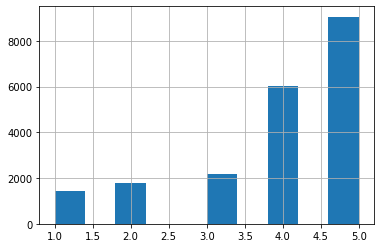

In [4]:
review_org_data['Rating'].hist()

# 2. Preprocessing

In [5]:
import re
import textacy
from textacy import preprocessing
from emoji_translate.emoji_translate import Translator
import nltk

nltk.download('stopwords')

emo = Translator(exact_match_only=False, randomize=True)


def remove_stopword(x):
    return [y for y in x.split(' ') if y not in stopwords.words('english')]


#     return (' ').join([y for y in x.split(' ') if y not in stopwords.words('english')])


def text_preprocessing(text):
    '''
     lowercase,remove whitespace,replace hashtaggs,phone_numers,urls,emails
     remove html_tags punctuation
     replace emoji by meaning
    '''
    text_new = text.lower()
    text_new = re.sub(' +', ' ', text_new)
    text_new = textacy.preprocessing.replace.hashtags(text_new, repl='_HASH_')
    text_new = textacy.preprocessing.replace.phone_numbers(text_new,
                                                           repl='_PHONENUM_')
    text_new = textacy.preprocessing.remove.html_tags(text_new)
    text_new = textacy.preprocessing.replace.urls(text_new, repl='_URL_')
    text_new = textacy.preprocessing.replace.emails(text_new, repl='_EMAIL_')
    text_new = textacy.preprocessing.remove.punctuation(text_new,
                                                        only=[",", ";", ":"])
    text_new = emo.demojify(text_new)
    return text_new

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# TODO: using parallel processing here to make it faster
review_org_data['clean_text'] = review_org_data['Review'].apply(
    lambda x: text_preprocessing(x))

# 3. Selecting features

In [7]:
# converting rating from 0 to 4
review_org_data['rating_from_0'] = review_org_data['Rating'].apply(
    lambda x: x - 1)
# checking text_length of reviews
review_org_data['text_length'] = review_org_data['clean_text'].apply(
    lambda x: len(x.split(" ")))

In [8]:
print('num of reviews having more than 512 words are ', end='')
print(
    len(review_org_data) -
    len(review_org_data[review_org_data['text_length'] < 512]))

num of reviews having more than 512 words are 262


In [9]:
# let's remove them
review_org_data = review_org_data[review_org_data['text_length'] < 512]

In [10]:
# review_org_data[review_org_data['rating_from_0'] == 4].sort_values('text_length',ascending=False)

# 4. Create train test split

In [11]:
from sklearn.model_selection import train_test_split
print('creating train and test split ....')

X = review_org_data['clean_text']
y = review_org_data['rating_from_0']


X_train, X_test, y_train, y_test = train_test_split(
        X, y,stratify=y, test_size=0.2, random_state = 2022)

X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, stratify=y_test, test_size=0.5,random_state = 2022)

creating train and test split ....


In [12]:
len(X_train),len(X_val),len(X_test)

(16183, 2023, 2023)

In [20]:
from collections import Counter
Counter(list(y_val)),Counter(list(y_test))

(Counter({0: 140, 3: 595, 2: 215, 4: 898, 1: 175}),
 Counter({4: 897, 3: 595, 0: 140, 1: 176, 2: 215}))

In [21]:
import torch
torch.cuda.is_available()

True

# 5. Load Model and test

In [33]:
import transformers as t

In [23]:
model_ckpt = "sentiment_analysis/checkpoint-20000/"
tokenizer = t.BertTokenizer.from_pretrained('bert-base-uncased')
model = t.BertForSequenceClassification.from_pretrained(model_ckpt, num_labels=5).to("cuda")
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [26]:
class Create_Dataset(torch.utils.data.Dataset):

    def __init__(self, reviews, ratings, tokenizer):

        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = tokenizer
        self.max_len = tokenizer.model_max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = str(self.reviews[index])
        ratings = self.ratings[index]

        encoded_review = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
            padding="max_length",
            truncation=True)

        return {
            'input_ids': encoded_review['input_ids'][0],
            'attention_mask': encoded_review['attention_mask'][0],
            'labels': torch.tensor(ratings, dtype=torch.long)
        }

In [27]:
test_dataset = Create_Dataset(
    reviews=list(X_test),
    ratings=list(y_test),
    tokenizer=tokenizer,
)

In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [29]:
test_trainer = t.Trainer(model)

In [30]:
final_pred = test_trainer.predict(test_dataset) 

***** Running Prediction *****
  Num examples = 2023
  Batch size = 8


In [32]:
from sklearn.metrics import classification_report
print(classification_report(list(final_pred.label_ids),list(final_pred.predictions.argmax(-1))))

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       140
           1       0.50      0.57      0.53       176
           2       0.47      0.45      0.46       215
           3       0.56      0.58      0.57       595
           4       0.78      0.77      0.78       897

    accuracy                           0.65      2023
   macro avg       0.61      0.60      0.60      2023
weighted avg       0.65      0.65      0.65      2023



# 6. analysis on the test data

In [59]:
device = 'cuda'

In [116]:
BATCH_SIZE = 8
def predict_batch(text):
    
    if isinstance(text, str):
        text = [ text ]
        
    NUMBER_OF_BATCHES = (BATCH_SIZE + len(text) - 1)//BATCH_SIZE
    
    predictions = []
    for i in range(NUMBER_OF_BATCHES):
        inputs = tokenizer.batch_encode_plus(text[i*BATCH_SIZE: (i+1)*BATCH_SIZE],
                                         padding=True,
                                         truncation=True,
                                         max_length=512,
                                         return_tensors="pt").to(device)
        each_batch_pred = torch.argmax(model(**inputs)['logits'],axis=1).detach().cpu().numpy().tolist()
        predictions.append(each_batch_pred)
    
    return predictions

In [117]:
batch_test_output = predict_batch(list(test_dataset.reviews))

In [118]:
batch_test_output = sum(batch_test_output,[])

In [119]:
test_df = pd.DataFrame({
    'test_review': list(test_dataset.reviews),
    'true_rating': list(test_dataset.ratings),
    'pred_rating': list(batch_test_output)
})

In [120]:
test_df['text_len'] = test_df['test_review'].apply(lambda x : len(x.split(' ')))
test_df['ratings_pred_diff'] = test_df.apply(lambda x : abs(x['true_rating']-x['pred_rating']) , axis=1)

In [121]:
test_df[test_df['true_rating'] == test_df['pred_rating']]['true_rating'].value_counts()

4    689
3    345
1    101
2     96
0     86
Name: true_rating, dtype: int64

In [122]:
test_df[test_df['true_rating'] != test_df['pred_rating']]['pred_rating'].value_counts()

3    270
4    191
2    109
1    102
0     34
Name: pred_rating, dtype: int64

In [123]:
test_df['pred_rating'].value_counts()

4    880
3    615
2    205
1    203
0    120
Name: pred_rating, dtype: int64

In [124]:
print(classification_report(list(test_df['true_rating']),list(test_df['pred_rating'])))

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       140
           1       0.50      0.57      0.53       176
           2       0.47      0.45      0.46       215
           3       0.56      0.58      0.57       595
           4       0.78      0.77      0.78       897

    accuracy                           0.65      2023
   macro avg       0.61      0.60      0.60      2023
weighted avg       0.65      0.65      0.65      2023



In [125]:
test_df[test_df['true_rating'] != test_df['pred_rating']].sort_values(['text_len'],ascending=False)

,test_review,true_rating,pred_rating,text_len,ratings_pred_diff
470,got married palace loved little background wif...,4,3,498,1
251,checked reviews booked trip sounded ok sounded...,1,0,490,1
1727,trip nyc spent long weekend westin times squar...,3,4,479,1
790,sunshine white beaches relaxation wow sunshin...,4,3,470,1
1657,great time husband 4 day 3 night vacation 5/1...,4,3,443,1
...,...,...,...,...,...
1147,2nd time allways good second time went hotel ...,4,3,19,1
1867,hotel residence henri iv great hotel recently ...,4,3,18,1
110,nice stayed silver cloud pre-cruise impressed...,4,3,17,1
458,miramar offers outstanding location great hong...,3,4,16,1


In [126]:
test_df[test_df['ratings_pred_diff'] > 2]

,test_review,true_rating,pred_rating,text_len,ratings_pred_diff
56,great time past week march 3rd 4 girlfriends s...,1,4,102,3
341,best manger went bambu june 19-26. punta cana ...,4,0,195,4
710,bril botel sarah chick tourmarch 23-26we grou...,4,1,69,3
765,best vac melia 5th feb 12th niece there3 wee...,4,1,129,3
960,best hotel barcelona read reviews hotel did no...,4,1,93,3
1222,finally non-smoking hotel say apart spot fin...,4,1,103,3
1281,loved hotel husband stayed embassy suites phoe...,0,3,66,3
1739,expensive great stayed marriott courtyard nigh...,4,1,78,3
1871,rent condo esj towers rented condo esj towers ...,4,1,75,3


In [128]:
test_df[test_df['ratings_pred_diff'] > 2].loc[1739]['test_review']

'expensive great stayed marriott courtyard night boarding caribbean cruise  choice mainly based fact hotels royal caribbean passengers cruise  expensive hours spent high standard close port  checkin 3pm checkout 12 noon  generally accommodating requested 1pm checkout maid not aware insisted leave 12 noon  taxi cost 12 14 port  negative breakfast extremely expensive  not worry supermarket couple eating places road  terms location good port appears little need prepared taxi tourist areas '

# 7. Final thoughts
## -- It is really hard to predict if the reviews are sometime positive or negative
## -- we see that the model is not failing a lot. Because It is not predicting totally opposit ratings. The predictions are nearby to the original rating and mostly off by 1 value
## -- In my test data I can see only 9 reviews were predicted totally wrong. As in the true rating and the predicted rating difference is more that 2, i.e if the true rating is 4(on a scale of 0-4), in some cases they are being predicted as 1 or 0.

# 8. TODO/Furure experiments
## -- try spelling corrector
## -- don't remove the stop words
## -- need to check if I can use better embeddings
## -- somewhere I saw people are using combination of tfidf and elmo embeddings, because tfidf works better with short text
## -- dataset sampling techniques for balancing or generating synthetic data